In [1]:
%cd ~/representations/minigrid_basics/

/home/httse/representations/minigrid_basics


In [2]:
import os
from os.path import join
import pickle
import numpy as np
import matplotlib.pyplot as plt
from examples.plotter import Plotter, Colors
from itertools import product

In [3]:
# build the file name given the hyperparameters
def construct_filename(p_option, dataset_size, learn_rep_iteration, representation_step_size, num_options, seed):
    values = [p_option, dataset_size, learn_rep_iteration, representation_step_size, num_options]
    values = [str(v) for v in values]
    filename = '-'.join(values) + f"-{seed}.pkl"
    return filename

In [ ]:
# read data given env_name, representation, and hyperparameters
def read_data(env_name, representation, p_option, dataset_size, learn_rep_iteration, representation_step_size, num_options, seed=20):
    path = join("experiments", "rod", env_name, representation)

    all_rewards = []
    all_visit_percentage = []


    for s in range(1, seed + 1):
        filename = construct_filename(p_option, dataset_size, learn_rep_iteration, representation_step_size, num_options, s)

        try:
            with open(join(path, filename), "rb") as f:
                data = pickle.load(f)

            all_rewards.append(data['rewards'])
            all_visit_percentage.append(data['visit_percentage'])
        except:
            pass

    # all_rewards = np.array(all_rewards)
    # for i in range(1, len(all_rewards[0])):
    #     all_rewards[:, i] += all_rewards[:, i - 1]


    return np.array(all_rewards), np.array(all_visit_percentage)
        

In [ ]:
# check how many seeds are present
def check_seed(env_name, representation, p_option, dataset_size, learn_rep_iteration, representation_step_size, num_options, seed=20):
    path = join("experiments", "rod", env_name, representation)


    successful_seeds = 0

    for s in range(1, seed + 1):
        filename = construct_filename(p_option, dataset_size, learn_rep_iteration, representation_step_size, num_options, s)
        # print(filename, os.path.isfile(join(path, filename)))
        # print(join(path, filename))

        successful_seeds += int(os.path.isfile(join(path, filename)))
    
    seed_missing = successful_seeds < 5
    # print(successful_seeds)

    return seed_missing, successful_seeds

In [6]:
## hyperparameters
p_option = [0.01, 0.05, 0.1]
dataset_size = [100, 100000]
learn_rep_iter = [1, 10, 100]
rep_lr = [0.01, 0.03, 0.1]
num_options = [1, 8, 1000]

In [42]:
def build_command(env, rep, p_option, dataset_size, learn_rep_iter, rep_lr, num_options):

    return f"sbatch --array=11-20 rod.sh {env} {rep} {p_option} {dataset_size} {learn_rep_iter} {rep_lr} {num_options}"

In [49]:
# check if some seeds missing
env = "gridmaze"
rep = "DR"
for x in product(p_option, dataset_size, learn_rep_iter, rep_lr, num_options):
    
    seed_missing, ss = check_seed(env, rep, *x)

    if seed_missing:
        # print(x, ss)
        print(build_command(env, rep, *x))
    

In [22]:
def compute_p_r_stat(env_name, representation):

    p_aucs = []
    r_cums = []
    for x in product(p_option, dataset_size, learn_rep_iter, rep_lr, num_options):
        r, p = read_data(env_name, representation, *x)

        p_auc = p.mean(0).mean()
        r_cum = r.mean(0).mean()    # actually average reward per step

        p_aucs.append(p_auc)
        r_cums.append(r_cum)

    return p_aucs, r_cums

In [24]:
p_auc_dict = {}
r_cum_dict = {}
# env_names = ["dayan", "dayan_2", "fourrooms", "fourrooms_2"]
env_names = ["gridmaze", "gridmaze_2"]
representation = ["SR", "DR"]

In [25]:
for env_name in env_names:
    p_auc_dict[env_name] = {}
    r_cum_dict[env_name] = {}

In [26]:
for env_name in env_names:
    print(env_name)
    for rep in representation:
        print(f"  {rep}")
        p_aucs, r_cums = compute_p_r_stat(env_name, rep,)

        path = join("experiments", "rod", env_name, rep)

        with open(join(path, "p_aucs.pkl"), "wb") as f:
            pickle.dump(p_aucs, f)

        with open(join(path, "r_cums.pkl"), "wb") as f:
            pickle.dump(r_cums, f)

        p_auc_dict[env_name][rep] = p_aucs
        r_cum_dict[env_name][rep] = r_cums
            

gridmaze
  SR
  DR
gridmaze_2
  SR
  DR


In [27]:
for env_name in env_names:
    print(env_name)
    for rep in representation:
        path = join("experiments", "rod", env_name, rep)

        with open(join(path, "p_aucs.pkl"), "rb") as f:
            p_auc_dict[env_name][rep] = pickle.load(f)

        with open(join(path, "r_cums.pkl"), "rb") as f:
            r_cum_dict[env_name][rep] = pickle.load(f)

gridmaze
gridmaze_2


In [28]:
plotter = Plotter()

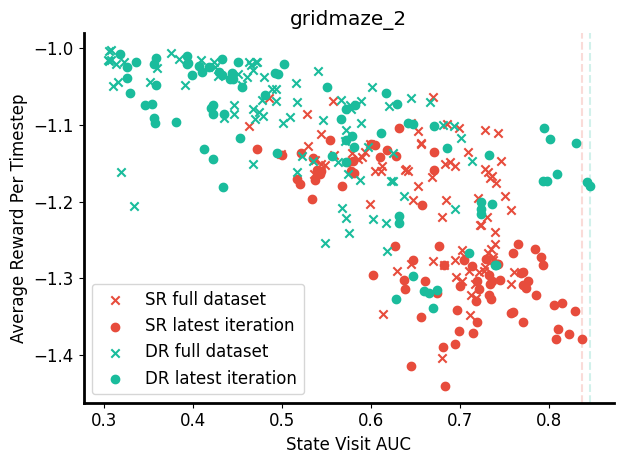

In [31]:
fig, ax = plt.subplots()

# check different between using full dataset, and using only the latest iteration
for env_name in ['gridmaze_2']:
    for j, rep in enumerate(representation):
        p_aucs = p_auc_dict[env_name][rep]
        r_cums = r_cum_dict[env_name][rep]

        p_auc_full_dataset = []
        p_auc_latest = []

        r_cum_full_dataset = []
        r_cum_latest = []

        for i, x in enumerate(product(p_option, dataset_size, learn_rep_iter, rep_lr, num_options)):
            if x[1] == 100:
                p_auc_latest.append(p_aucs[i])
                r_cum_latest.append(r_cums[i])
            else:
                p_auc_full_dataset.append(p_aucs[i])
                r_cum_full_dataset.append(r_cums[i])

        c = Colors.colors[j]

        plt.scatter(p_auc_full_dataset, r_cum_full_dataset, color=c, marker="x", label=f"{rep} full dataset")
        plt.scatter(p_auc_latest, r_cum_latest, color=c, marker="o", label=f"{rep} latest iteration")

        plt.axvline(np.max(p_aucs), color=c, linestyle='--', alpha=0.2)

    plotter.finalize_plot(ax, title=env_name, xlabel="State Visit AUC", ylabel="Average Reward Per Timestep")
    plt.legend()
    plt.show()

        
        

<bound method Plotter.axis_setting of <examples.plotter.Plotter object at 0x7f4718df6440>>


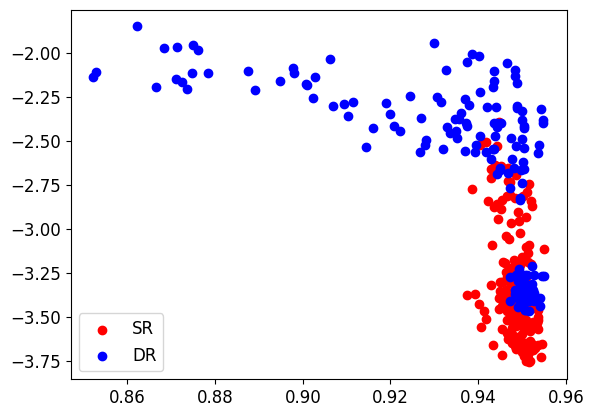

In [31]:
fig, ax = plt.subplots()
for env_name in ["dayan_2"]:
    for rep, c in zip(representation, ["red", "blue"]):
        plt.scatter(p_auc_dict[env_name][rep], r_cum_dict[env_name][rep], color=c, label=rep)

    plt.legend()
    plt.show()

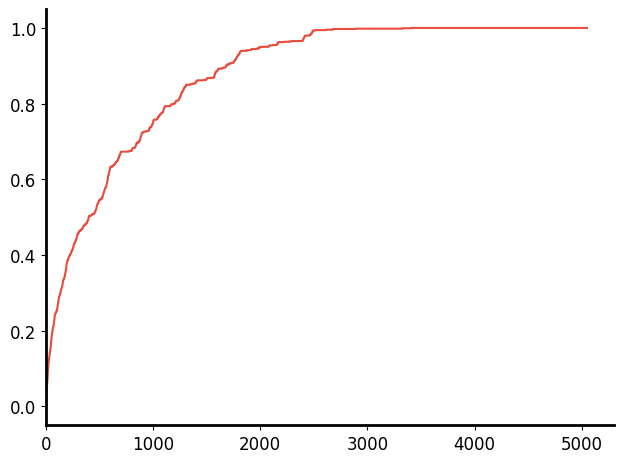

In [87]:
fig, ax = plt.subplots()

plotter = Plotter()

# plotter.plot_data(ax, x, p, plot_conf_int=False, plot_all_seeds=False)
# plotter.finalize_plot(ax)


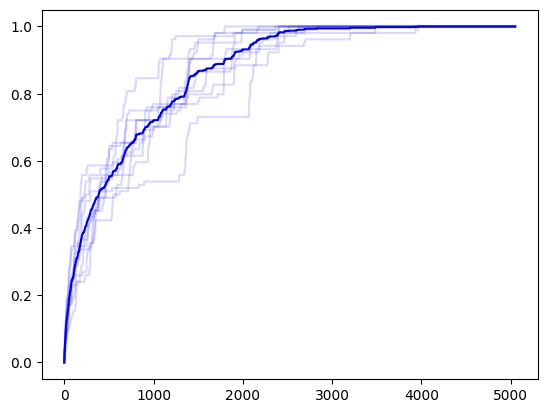

In [64]:
# # plt.plot(r.mean(0))
# color = 'blue'

# for pp in p:
#     plt.plot(pp, color=color, alpha=0.15)

# plt.plot(p.mean(0), color=color)

# # plt.fill_between(range(5051), p_mean - p_std, p_mean + p_std, color='blue', alpha=0.2)